新增用户留存率=新增用户中登录用户数/新增用户数*100%（一般统计周期为天）

In [1]:
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
# ! export MODIN_ENGINE=ray
# import os
# os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
from dask.diagnostics import ProgressBar as pb
import seaborn as sns

In [4]:
# dates=[1, 2, 3, 4]
# uid_set = [set([1,3]), set([1,2,3,4,9,5]), set([1,0,2,5,10,20]), set([30,9,3,7,5])]

# accumulation of all users
def set_cum_f(set_array):
    set_cum = []
    set_cum.append(set_array[0])
    for i in range(1,len(set_array)):
        set_cum.append(set_cum[i-1]|set_array[i])
    return set_cum

# calc new users
def set_dif_f(set_cum):
    set_dif = []
    for i in range(1,len(set_cum)):
        set_dif.append(set_cum[i] - set_cum[i-1])
    return set_dif

# calc retention rate
def stay_calc(uid_set, new_uid_set):
    result=np.zeros([len(new_uid_set),len(new_uid_set)])
    for i in range(len(new_uid_set)):
            for j in range(len(new_uid_set)):
                try:
                    result[i,j] = len(new_uid_set[i] & uid_set[j+1]) / len(new_uid_set[i])
                except ZeroDivisionError:
                    result[i,j] = np.nan
    return result
# stay_calc(uid_set)

In [5]:
def stay_rate_uid(test=True):
    if test == True:
        df = dd.read_csv('df1.csv')
    else:
        df = dd.read_csv('processed.csv') #read processed df
        df = df.drop('Unnamed: 0', axis=1)
        
    # df['time'] = [i.split(' ')[0] for i in df.time]
    # df['time'] = dd.to_datetime(df['time'])
    # df['time'] = df['time'].astype('datetime64[D]')
    # df = df.loc[(pd.Timestamp(2017,11,24)<=df['time']) & (df['time']<=pd.Timestamp(2017,12,3))]
    # df = df.set_index('time')
    # time processing
    df.time = dd.to_datetime(df['time'])
    df.time = df.time.astype('datetime64[D]')
    df = df.loc[(pd.Timestamp(2017,11,24)<=df['time']) & (df['time']<=pd.Timestamp(2017,12,3))]
    df.time = df.time.astype('string')

    # all users
    dates = pd.date_range("2017-11-24", periods=10, freq="1D").astype('string')

    uid_list = [df['uid'].loc[df.time==i] for i in dates]
    uid_set = [set(i) for i in uid_list]
    return uid_set
    
    
def stay_rate(uid_set):
    # new users
    uid_set = stay_rate_uid(False)
    uid_cum = set_cum_f(uid_set)
    new_uid_set = set_dif_f(uid_cum)

    # calculate retention rate
    result = stay_calc(uid_set, new_uid_set)
    return result

In [6]:
# calculate retention rate
uid_set = stay_rate_uid(False)
stay_rate = stay_rate(uid_set)

In [7]:
# save result
import pickle

with open('uid_set.txt','wb') as file:
    pickle.dump(uid_set, file)
    
with open('stay_rate.txt','wb') as file2:
    pickle.dump(stay_rate, file2)

In [10]:
stay_rate

array([[1.        , 0.76426554, 0.74623744, 0.7371064 , 0.7419836 ,
        0.7488168 , 0.76810442, 0.95936092, 0.93945908],
       [0.        , 1.        , 0.64144174, 0.63847946, 0.65280194,
        0.66511842, 0.69685509, 0.94530565, 0.92083088],
       [0.        , 0.        , 1.        , 0.60986593, 0.62092701,
        0.64378542, 0.67871513, 0.93654436, 0.90524459],
       [0.        , 0.        , 0.        , 1.        , 0.6164718 ,
        0.64164374, 0.680674  , 0.92922971, 0.89951857],
       [0.        , 0.        , 0.        , 0.        , 1.        ,
        0.69622224, 0.73609531, 0.9277974 , 0.89576723],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.91625846, 0.92558899, 0.88791696],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.83464567, 0.84251969],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.7       ],


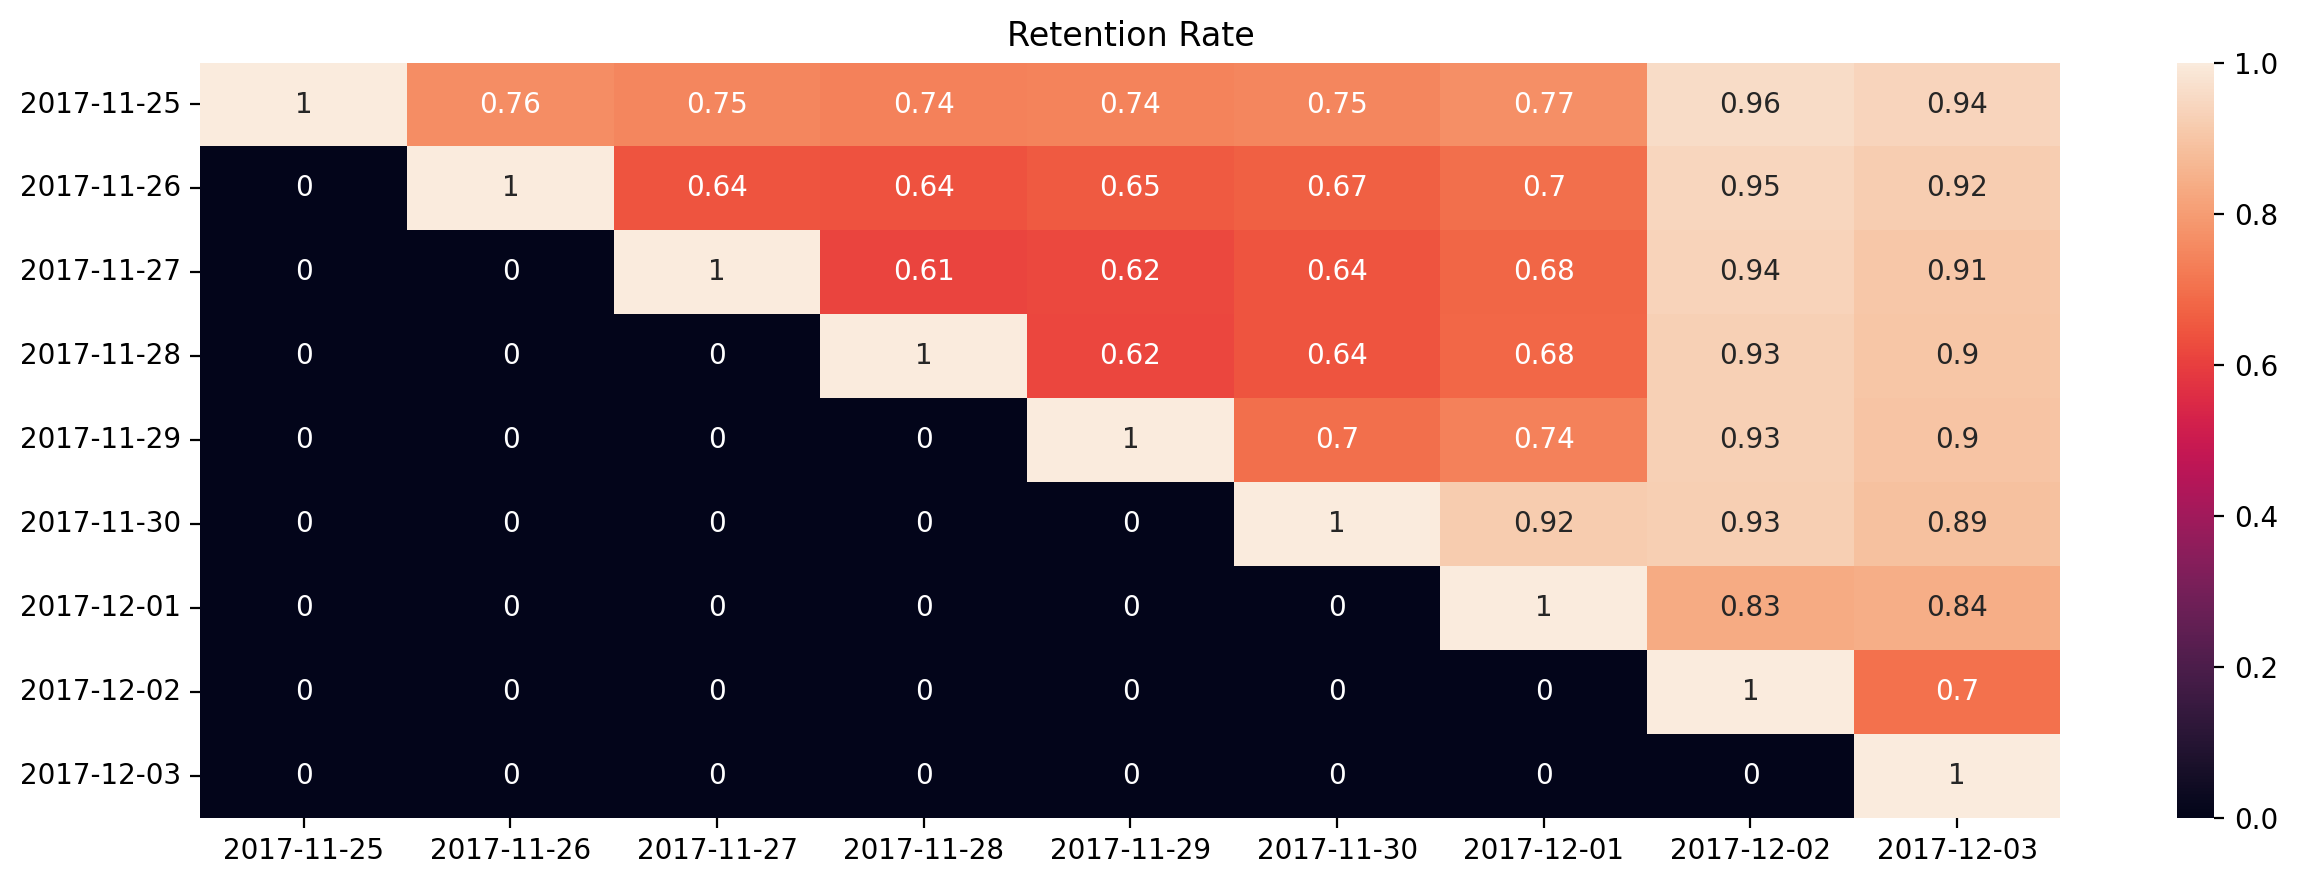

In [27]:
plt.figure(dpi=200,figsize=[15,5])
plt.title('Retention Rate')
dates = pd.date_range("2017-11-25", periods=9, freq="1D").astype('string')
plot_data = pd.DataFrame(stay_rate,index=dates,columns=dates)
sns.heatmap(plot_data, annot=True)
plt.savefig('6-1.jpg')

In [51]:
# from distributed import Client

# client = Client()
# import warnings
# warnings.filterwarnings('ignore')
# import ray
# ray.init()

In [44]:
def repurchase(test=True):
    if test == True:
        df = dd.read_csv('df1.csv')
    else:
        df = dd.read_csv('processed.csv')
        df = df.drop('Unnamed: 0', axis=1)
    
    # repurchase calculation
    df = df.loc[df.action=='buy']
    df = df.groupby('uid')['action'].count()
    df = df.loc[df>1]
    df = df.reset_index()
    df = df.groupby('action')['uid'].count()
    df = df.compute()
    
    # plot
    plt.figure(dpi=200,figsize=[15,5])
    plt.title('Repurchase')
    sns.barplot(y=df, x=df.index)
    plt.xlim([-0.5,20])
    plt.xlabel('Repurchase Count')
    plt.ylabel('User Count')
    plt.savefig('Repurchase.jpg')

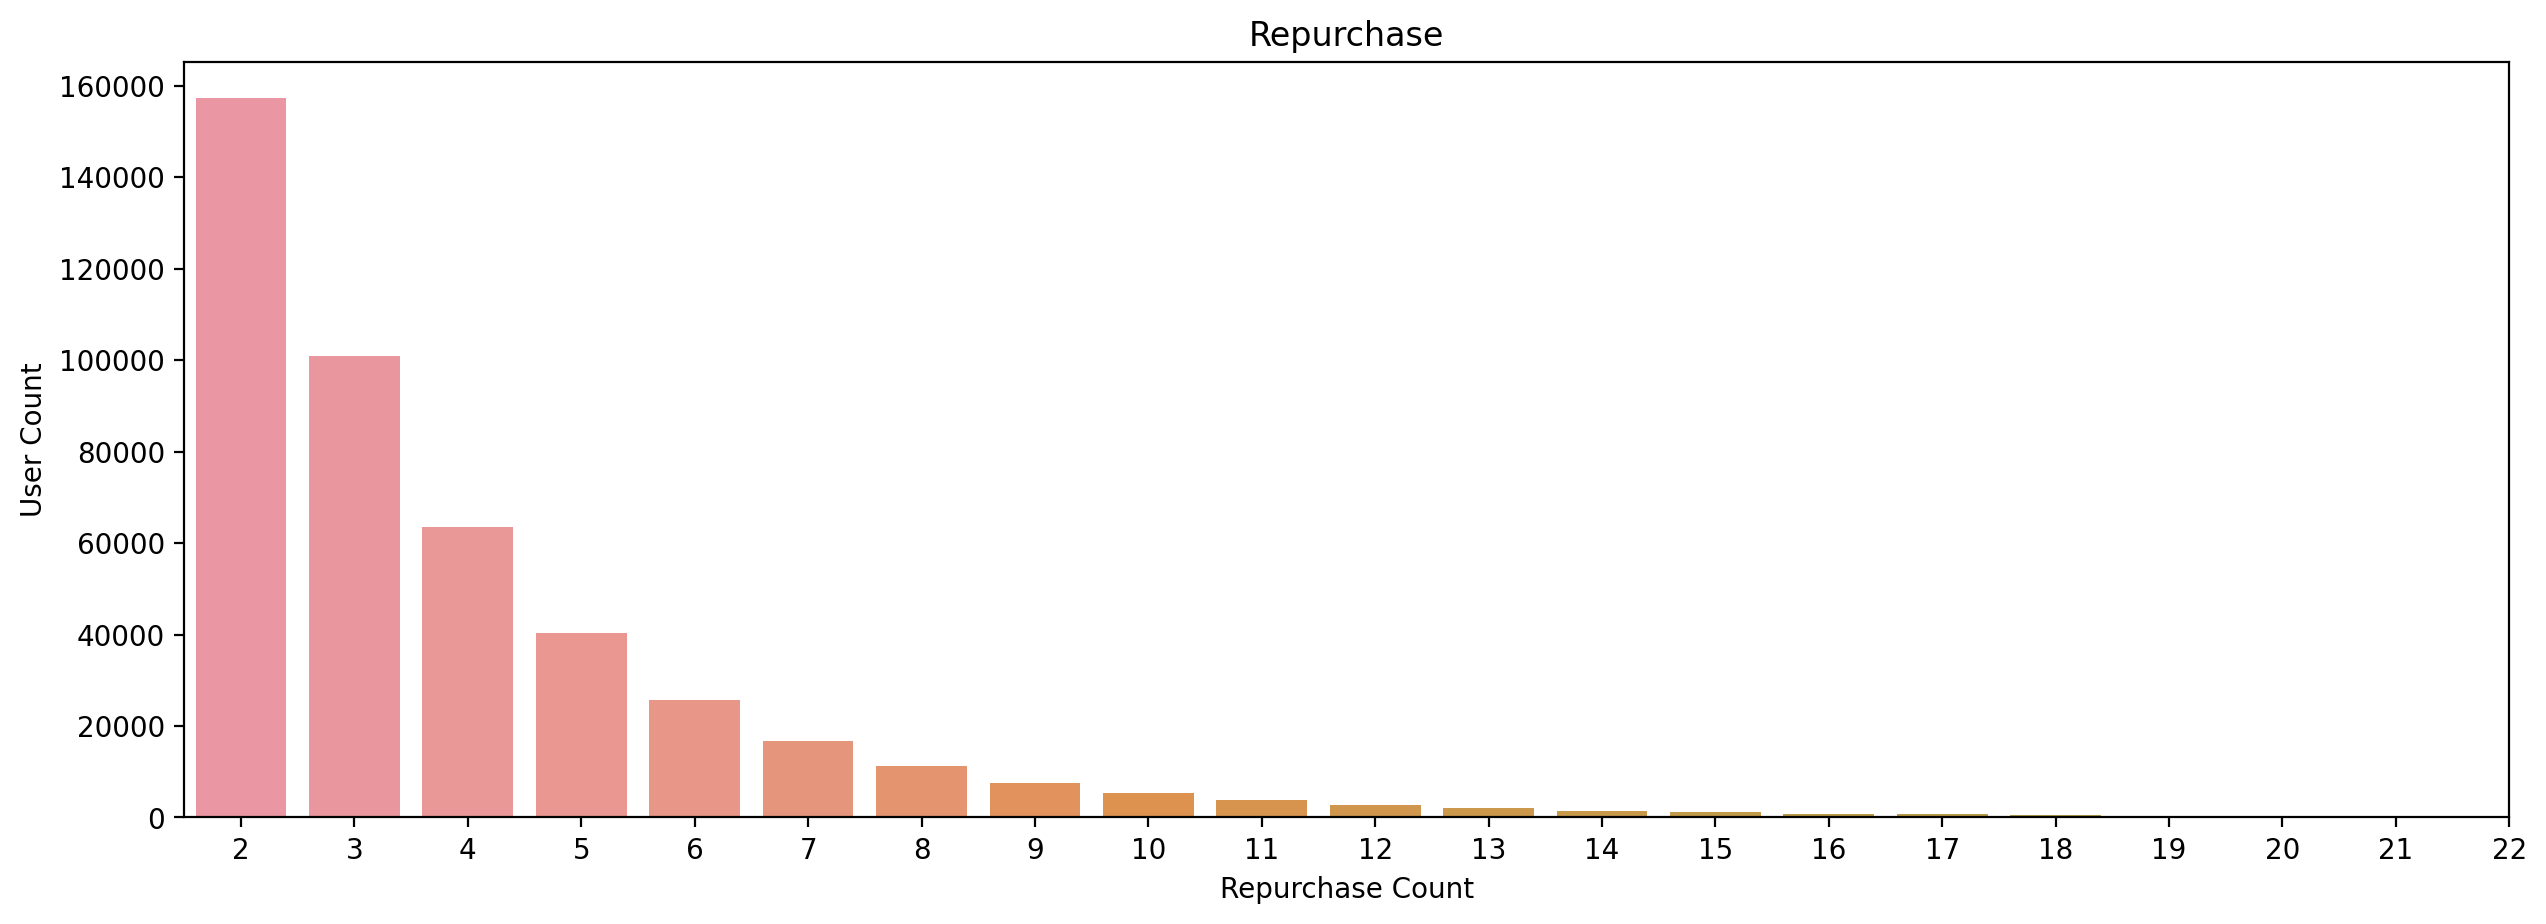

In [45]:
repurchase(False)

In [2]:
def get_hour(a):
    return a.hour
def day_activity(test=True):
    if test == True:
        df = dd.read_csv('df1.csv')
    else:
        df = dd.read_csv('processed.csv')
        df = df.drop('Unnamed: 0', axis=1)
    
    # adjust time format to hour    
    df.time = dd.to_datetime(df['time'])
    df['time'] = df['time'].apply(get_hour,meta=('time', 'int32'))
    df_main = df.groupby('time')['uid'].count()
    with pb(minimum=1.0):
        df_main = df_main.compute()
    
    # all actions plot
    plt.figure(dpi=200,figsize=[15,5])
    plt.style.use('ggplot')
    plt.title('Day Activity')
    sns.lineplot(y=df_main, x=df_main.index,label='all actions')
    
    # sub actions plot
    for action in ['buy','fav','cart','pv']:
        print('dealing '+action)
        df_sub = df.loc[df.action==action].groupby('time')['uid'].count()
        with pb(minimum=1.0):
            df_sub = df_sub.compute()
        sns.lineplot(y=df_sub, x=df_sub.index,label=action)
        
    # plt.xlim([-0.5,20])
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Activity Count')
    plt.savefig('Day Activity.jpg')

[########################################] | 100% Completed |  7min 25.4s
dealing buy
[########################################] | 100% Completed |  7min 28.8s
dealing fav
[########################################] | 100% Completed |  7min 30.3s
dealing cart
[########################################] | 100% Completed |  7min 28.1s
dealing pv
[########################################] | 100% Completed |  7min 30.0s


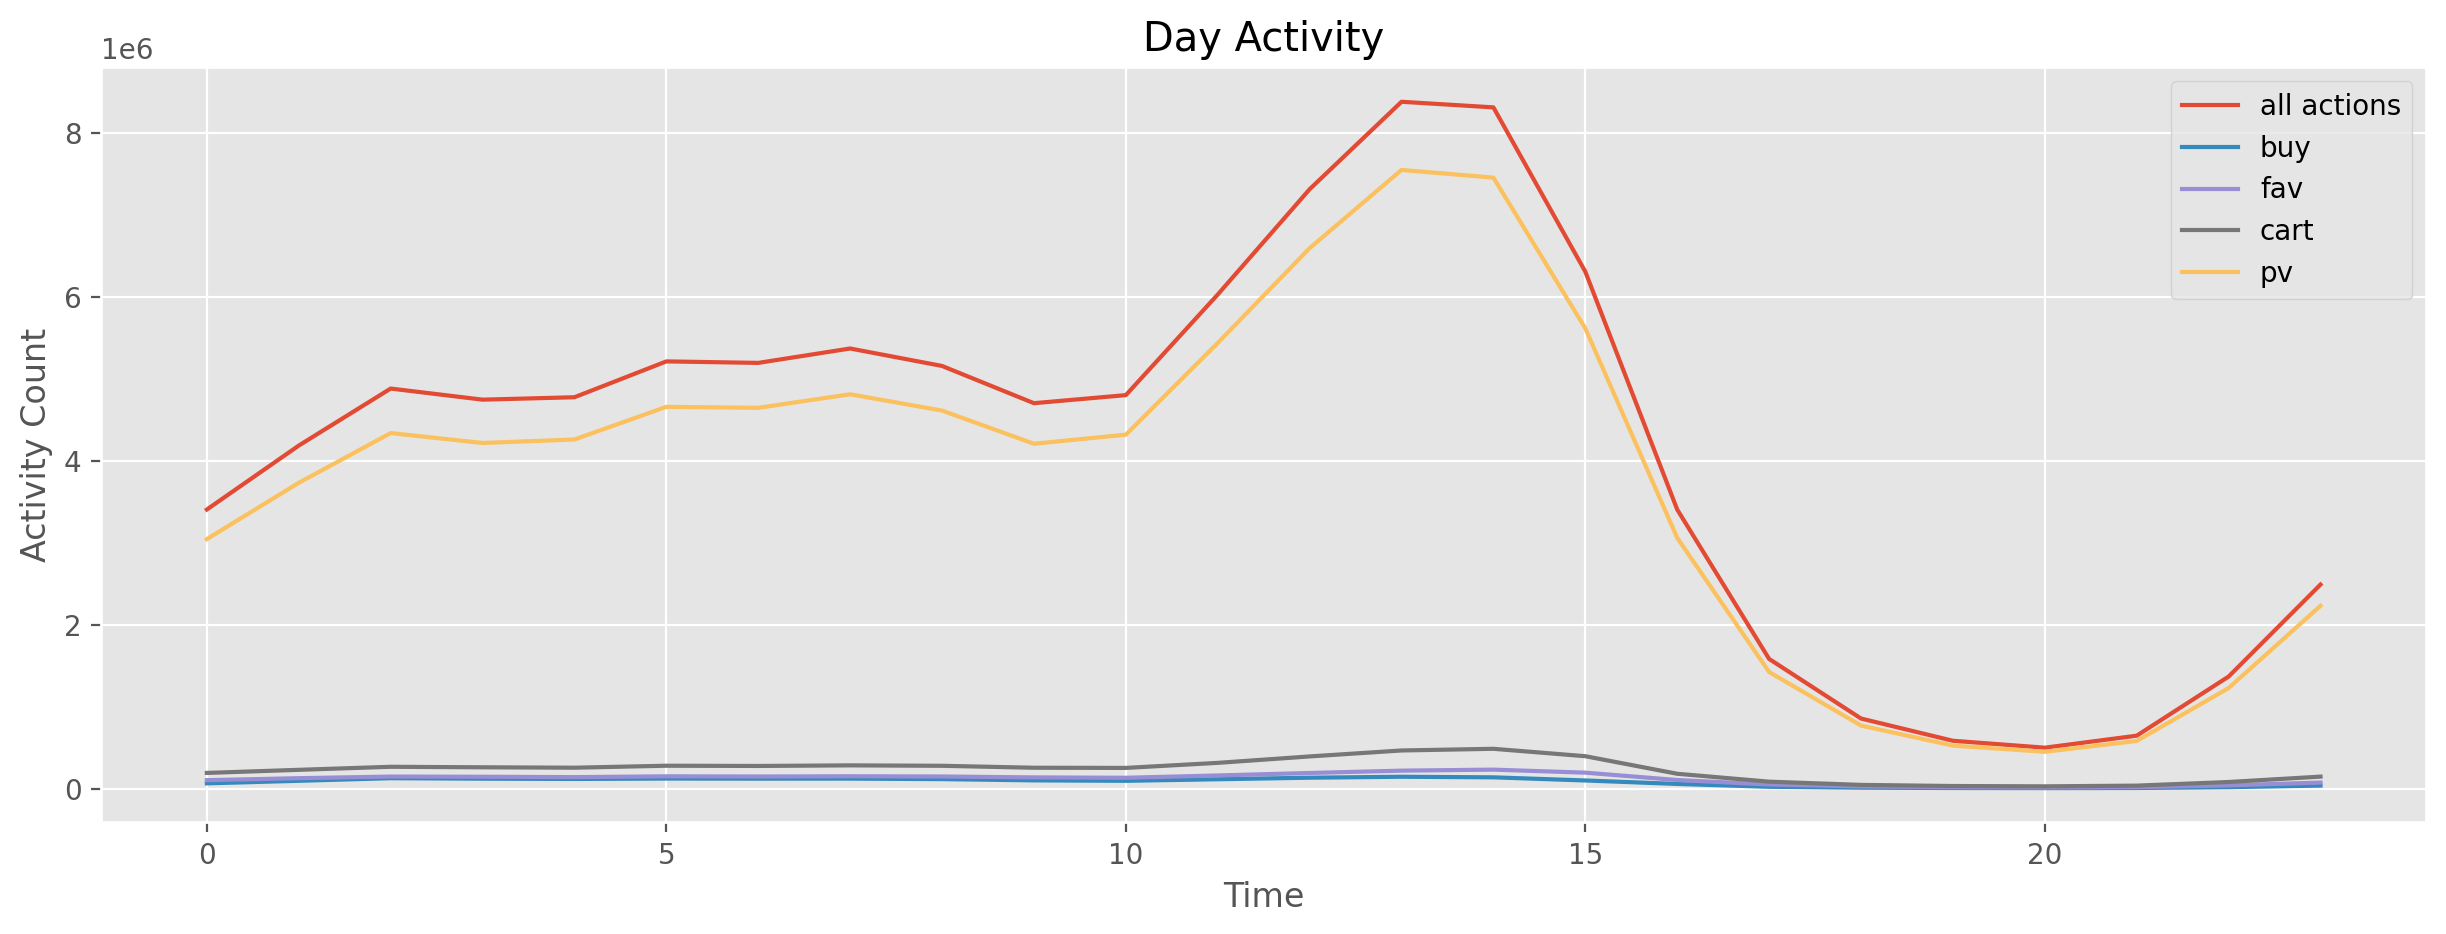

In [3]:
day_activity(False)

分析：分析上面的留存图，可以发现用户在2号3号回归很多。查阅日历，这两天恰好是周六周日，可以认为用户的活跃集中在周末。分析以小时为尺度的活跃度图，可以发现活跃度中贡献最大的还是浏览行为，变化情况和总趋势基本一致。总的来看，一天当中，上午时段活跃度基本稳定，而最活跃的时段在12点半到15点，对应大多数用户的午休时间，此后不断下降。活跃度最低的在20点左右，猜测是大多数用户在家进行别的娱乐活动。20点后第二天凌晨活跃度都不断回升，应该是有相当一部分用户有熬夜使用手机的情况。